# Comparing Graph-based and Vector-based RAG Systems (Part 2 of a Series): Retrieval using Graph Structures vs Vector DB Structures

**TLDR:**

I evaluated Knowledge Graph-based RAG against traditional vector-based methods using Neo4j and FAISS. This comparison was prompted by a Microsoft paper on GraphRAG that lacked clear metrics and quantifiable improvements, potentially due to vested interests in promoting their technology.

**Context:**

After reviewing Microsoft's GraphRAG paper, which didn't justify the additional engineering and compute costs for GraphRAG, especially for dynamic documents, I decided to test knowledge graph performance myself. This post (Part 2) compares graph retrieval (Neo4j) vs. vector database retrieval (FAISS), building on the database comparison from Part 1 (which was comparing the same retrievers of the vector database componenents of Neo4j vs FAISS. The goal is to assess if GraphRAG's performance (when retrieving its graph components) justifies its increased complexity and resource requirements.

---

**Methodology:**

My approach below, for evaluation of each GraphRAG vs a Vector DB:

1. Set up the environment.
2. Processed the input data (used the same document as Part 1 - the June 2024 US Presidential Debate transcript).
3. Used the above chunks to create a knowledge graph in Neo4j with GPT-3.5-Turbo (to see if any lift from small model).
4. Setup FAISS retriever with comparable chunking
5. Generated ground truth from the document to evaluate performance of each.
6. Same as Part 1: Evaluated on RAGAS metrics and plotted results of the vector database side for each.
7. Created a function containing a cypher query to transverse the knowledge graph.
8. Now, unique to Part 2: Evaluated on RAGAS metrics for the graph transversal retrieval of the graph database vs the FAISS vector database baseline.


---
**Microsoft GraphRAG paper I'm referring to:** 

https://arxiv.org/pdf/


### Step 1: Chunking the RAG content, Ingestion into Neo4j and setting up 3 retrievers

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [49]:
# Import packages
import os
import asyncio 
import nest_asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from typing import List, Dict, Union
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Neo4jVector, FAISS
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema import Document
from neo4j import GraphDatabase 
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_relevancy, context_recall
from datasets import Dataset
import random
import re
from tqdm.asyncio import tqdm
from concurrent.futures import ThreadPoolExecutor

In [3]:
# Set up API keys 
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
neo4j_url = os.getenv("NEO4J_URL")
neo4j_user = os.getenv("NEO4J_USER")
neo4j_password = os.getenv("NEO4J_PASSWORD")


In [61]:
# Load and process the PDF
pdf_path = "debate_transcript.pdf"
loader = PyPDFLoader(pdf_path)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) # Comparable to Neo4j
texts = text_splitter.split_documents(documents)

In [5]:
# Set up Neo4j connection
driver = GraphDatabase.driver(neo4j_url, auth=(neo4j_user, neo4j_password))


In [6]:
# Function to clear the Neo4j instance 
def clear_neo4j_data(tx):
    tx.run("MATCH (n) DETACH DELETE n")


In [60]:
# Function to create graph structure using gpt4 turbo
def create_graph_structure(tx, texts):
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    
    for text in tqdm(texts, desc="Creating graph structure"):
        prompt = ChatPromptTemplate.from_template(
            "Given the following text, identify key entities and their relationships. "
            "Format the output as a list of tuples, each on a new line: (entity1, relationship, entity2)\n\n"
            "Text: {text}\n\n"
            "Entities and Relationships:"
        )
        
        response = llm(prompt.format_messages(text=text.page_content))
        
        # Process the response and create nodes and relationships
        lines = response.content.strip().split('\n')
        for line in lines:
            if line.startswith('(') and line.endswith(')'):
                parts = line[1:-1].split(',')
                if len(parts) == 3:
                    entity1, relationship, entity2 = [part.strip() for part in parts]
                    # Create nodes and relationship
                    query = (
                        "MERGE (e1:Entity {name: $entity1}) "
                        "MERGE (e2:Entity {name: $entity2}) "
                        "MERGE (e1)-[:RELATED {type: $relationship}]->(e2)"
                    )
                    tx.run(query, entity1=entity1, entity2=entity2, relationship=relationship)




In [38]:
def ensure_vector_index(recreate=False):
    with driver.session() as session:
        result = session.run("""
        SHOW INDEXES
        YIELD name, labelsOrTypes, properties
        WHERE name = 'entity_index'
          AND labelsOrTypes = ['Entity']
          AND properties = ['embedding']
        RETURN count(*) > 0 AS exists
        """).single()
        
        index_exists = result['exists'] if result else False

        if index_exists and recreate:
            session.run("DROP INDEX entity_index")
            print("Existing vector index 'entity_index' dropped.")
            index_exists = False

        if not index_exists:
            session.run("""
            CALL db.index.vector.createNodeIndex(
              'entity_index',
              'Entity',
              'embedding',
              1536,
              'cosine'
            )
            """)
            print("Vector index 'entity_index' created successfully.")
        else:
            print("Vector index 'entity_index' already exists. Skipping creation.")




In [52]:
def add_embeddings_to_entities(tx, embeddings):
    query = """
    MATCH (e:Entity)
    WHERE e.embedding IS NULL
    WITH e LIMIT 100
    SET e.embedding = $embedding
    """
    entities = tx.run("MATCH (e:Entity) WHERE e.embedding IS NULL RETURN e.name AS name LIMIT 100").data()
    for entity in tqdm(entities, desc="Adding embeddings"):
        embedding = embeddings.embed_query(entity['name'])
        tx.run(query, embedding=embedding)


In [50]:
# Embeddings model w default OAI embeddings model
embeddings = OpenAIEmbeddings()

In [51]:
# Create FAISS retriever
faiss_vector_store = FAISS.from_documents(texts, embeddings)
faiss_retriever = faiss_vector_store.as_retriever(search_kwargs={"k": 2})


In [62]:
# Neo4j retrieiver 
def create_neo4j_retriever():
    # Clear existing data
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
    
    # Create graph structure
    with driver.session() as session:
        session.execute_write(create_graph_structure, texts)
    
    # Add embeddings to entities
    with driver.session() as session:
        max_attempts = 10
        attempt = 0
        while attempt < max_attempts:
            count = session.execute_read(lambda tx: tx.run("MATCH (e:Entity) WHERE e.embedding IS NULL RETURN COUNT(e) AS count").single()['count'])
            if count == 0:
                break
            session.execute_write(add_embeddings_to_entities, embeddings)
            attempt += 1
        if attempt == max_attempts:
            print("Warning: Not all entities have embeddings after maximum attempts.")
    
    # Create Neo4j retriever
    neo4j_vector_store = Neo4jVector.from_existing_index(
        embeddings,
        url=neo4j_url,
        username=neo4j_user,
        password=neo4j_password,
        index_name="entity_index",
        node_label="Entity",
        text_node_property="name",
        embedding_node_property="embedding"
    )
    return neo4j_vector_store.as_retriever(search_kwargs={"k": 2})

In [63]:
# Create RAG chain function - same embeddings model for all 
def create_rag_chain(retriever):
    llm = ChatOpenAI(model_name="gpt-3.5-turbo")
    template = """Answer the question based on the following context:
    {context}
    
    Question: {question}
    Answer:"""
    prompt = PromptTemplate.from_template(template)
    
    return (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

In [64]:
# Associate databases with RAG chain functions
faiss_rag_chain = create_rag_chain(faiss_retriever)
neo4j_rag_chain = create_rag_chain(neo4j_retriever)


In [42]:
# Create ground truth 
def create_ground_truth(texts: List[Union[str, Document]], num_questions: int = 100) -> List[Dict]:
    llm_ground_truth = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.2)
    
    def get_text(item):
        return item.page_content if isinstance(item, Document) else item
    
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    all_splits = text_splitter.split_text(' '.join(get_text(doc) for doc in texts))
    
    ground_truth = []
    
    question_prompt = ChatPromptTemplate.from_template(
        "Given the following text, generate {num_questions} diverse and specific questions that can be answered based on the information in the text. "
        "Provide the questions as a numbered list.\n\nText: {text}\n\nQuestions:"
    )
    
    all_questions = []
    for split in tqdm(all_splits, desc="Generating questions"):
        response = llm_ground_truth(question_prompt.format_messages(num_questions=3, text=split))
        questions = response.content.strip().split('\n')
        all_questions.extend([q.split('. ', 1)[1] if '. ' in q else q for q in questions])
    
    random.shuffle(all_questions)
    selected_questions = all_questions[:num_questions]
    
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
    
    for question in tqdm(selected_questions, desc="Generating ground truth"):
        answer_prompt = ChatPromptTemplate.from_template(
            "Given the following question, provide a concise and accurate answer based on the information available. "
            "If the answer is not directly available, respond with 'Information not available in the given context.'\n\nQuestion: {question}\n\nAnswer:"
        )
        answer_response = llm(answer_prompt.format_messages(question=question))
        answer = answer_response.content.strip()
        
        context_prompt = ChatPromptTemplate.from_template(
            "Given the following question and answer, provide a brief, relevant context that supports this answer. "
            "If no relevant context is available, respond with 'No relevant context available.'\n\n"
            "Question: {question}\nAnswer: {answer}\n\nRelevant context:"
        )
        context_response = llm(context_prompt.format_messages(question=question, answer=answer))
        context = context_response.content.strip()
        
        ground_truth.append({
            "question": question,
            "answer": answer,
            "context": context,
        })
    
    return ground_truth


In [55]:
# Evaluation function
async def evaluate_rag_async(rag_chain, ground_truth, name):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    generated_answers = []
    for item in tqdm(ground_truth, desc=f"Evaluating {name}"):
        question = splitter.split_text(item["question"])[0]

        try:
            answer = await rag_chain.ainvoke(question)
        except AttributeError:
            answer = rag_chain.invoke(question)

        truncated_answer = splitter.split_text(str(answer))[0]
        truncated_context = splitter.split_text(item["context"])[0]
        truncated_ground_truth = splitter.split_text(item["answer"])[0]

        generated_answers.append({
            "question": question,
            "answer": truncated_answer,
            "contexts": [truncated_context],
            "ground_truth": truncated_ground_truth
        })

    dataset = Dataset.from_pandas(pd.DataFrame(generated_answers))

    result = evaluate(
        dataset,
        metrics=[
            context_relevancy,
            faithfulness,
            answer_relevancy,
            context_recall,
        ]
    )

    return {name: result}


In [56]:
async def run_evaluations(rag_chains, ground_truth):
    results = {}
    for name, chain in rag_chains.items():
        result = await evaluate_rag_async(chain, ground_truth, name)
        results.update(result)
    return results


In [57]:
# Main execution function
async def main():
    # Ensure vector index
    ensure_vector_index(recreate=True)
    
    # Create retrievers
    neo4j_retriever = create_neo4j_retriever()
    
    # Create RAG chains
    faiss_rag_chain = create_rag_chain(faiss_retriever)
    neo4j_rag_chain = create_rag_chain(neo4j_retriever)
    
    # Generate ground truth
    ground_truth = create_ground_truth(texts)
    
    # Run evaluations
    rag_chains = {
        "FAISS": faiss_rag_chain,
        "Neo4j": neo4j_rag_chain
    }
    results = await run_evaluations(rag_chains, ground_truth)
    return results

In [58]:
def plot_results(results):
    metrics = list(next(iter(results.values())).keys())
    chains = list(results.keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar_width = 0.35
    opacity = 0.8
    index = np.arange(len(metrics))
    
    for i, chain in enumerate(chains):
        means = [results[chain][metric] for metric in metrics]
        
        bars = ax.bar(index + i*bar_width, means, bar_width,
               alpha=opacity,
               label=chain)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', rotation=0)
    
    ax.set_xlabel('RAGAS Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('FAISS vs Neo4j: RAGAS Evaluation Results')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()



Existing vector index 'entity_index' dropped.
Vector index 'entity_index' created successfully.


Evaluating: 100%|█████████████████████████████| 400/400 [01:07<00:00,  5.90it/s]


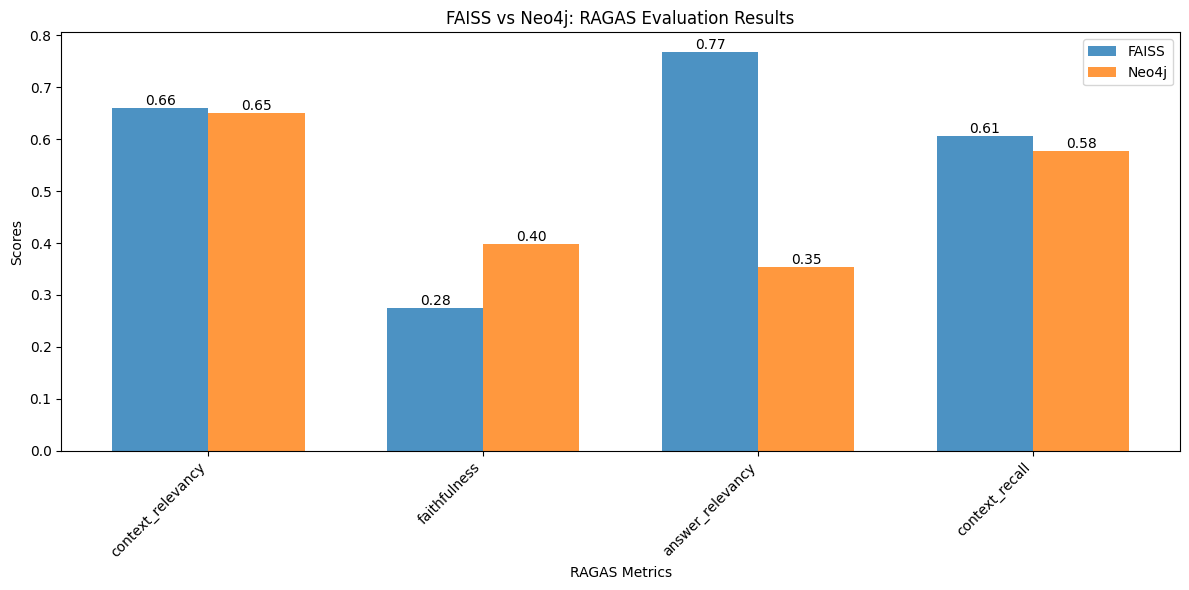

Results for FAISS:
{'context_relevancy': 0.6592, 'faithfulness': 0.2751, 'answer_relevancy': 0.7675, 'context_recall': 0.6067}

Results for Neo4j:
{'context_relevancy': 0.6508, 'faithfulness': 0.3986, 'answer_relevancy': 0.3541, 'context_recall': 0.5767}



In [59]:
if __name__ == "__main__":
    nest_asyncio.apply()
    try:
        results = asyncio.run(asyncio.wait_for(main(), timeout=7200))  # 2 hour timeout
        plot_results(results)
        
        # Print detailed results
        for name, result in results.items():
            print(f"Results for {name}:")
            print(result)
            print()
    except asyncio.TimeoutError:
        print("Evaluation timed out after 2 hours.")
    finally:
        # Close the Neo4j driver
        driver.close()

In [86]:
# to retrieve from neo4j using cypher rather than the vector db
def cypher_retriever(search_term: str) -> List[Document]:
    with driver.session() as session:
        result = session.run(
            """
            MATCH (e:Entity)
            WHERE e.name CONTAINS $search_term
            RETURN e.name AS name, [(e)-[r:RELATED]->(related) | related.name + ' (' + r.type + ')'] AS related
            LIMIT 2
            """,
            search_term=search_term
        )
        documents = []
        for record in result:
            content = f"Entity: {record['name']}\nRelated: {', '.join(record['related'])}"
            documents.append(Document(page_content=content))
        return documents

In [68]:
# create a function that combines these retrievers 
def setup_retrievers(texts):
    # FAISS retriever
    embeddings = OpenAIEmbeddings()
    faiss_vector_store = FAISS.from_documents(texts, embeddings)
    faiss_retriever = faiss_vector_store.as_retriever(search_kwargs={"k": 2})

    # Neo4j Cypher retriever
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")
        session.execute_write(create_graph_structure, texts)

    return faiss_retriever, cypher_retriever

In [69]:
# recreate the rag chain 
def create_rag_chain(retriever):
    llm = ChatOpenAI(model_name="gpt-3.5-turbo")
    template = """Answer the question based on the following context:
    {context}
    
    Question: {question}
    Answer:"""
    prompt = PromptTemplate.from_template(template)
    
    if callable(retriever):
        # For Cypher retriever
        retriever_func = lambda q: retriever(q)
    else:
        # For FAISS retriever
        retriever_func = retriever
    
    return (
        {"context": retriever_func, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )


In [70]:
# evaluate, using the same ground truth as before
async def evaluate_rag_async(rag_chain, ground_truth, name):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    generated_answers = []
    for item in tqdm(ground_truth, desc=f"Evaluating {name}"):
        question = splitter.split_text(item["question"])[0]

        try:
            answer = await rag_chain.ainvoke(question)
        except AttributeError:
            answer = rag_chain.invoke(question)

        truncated_answer = splitter.split_text(str(answer))[0]
        truncated_context = splitter.split_text(item["context"])[0]
        truncated_ground_truth = splitter.split_text(item["answer"])[0]

        generated_answers.append({
            "question": question,
            "answer": truncated_answer,
            "contexts": [truncated_context],
            "ground_truth": truncated_ground_truth
        })

    dataset = Dataset.from_pandas(pd.DataFrame(generated_answers))

    result = evaluate(
        dataset,
        metrics=[
            context_relevancy,
            faithfulness,
            answer_relevancy,
            context_recall,
        ]
    )

    return {name: result}



In [71]:
async def run_evaluations(rag_chains, ground_truth):
    results = {}
    for name, chain in rag_chains.items():
        result = await evaluate_rag_async(chain, ground_truth, name)
        results.update(result)
    return results



In [72]:
# New Plot
def plot_results(results):
    metrics = list(next(iter(results.values())).keys())
    chains = list(results.keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar_width = 0.35
    opacity = 0.8
    index = np.arange(len(metrics))
    
    for i, chain in enumerate(chains):
        means = [results[chain][metric] for metric in metrics]
        
        bars = ax.bar(index + i*bar_width, means, bar_width,
               alpha=opacity,
               label=chain)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom', rotation=0)
    
    ax.set_xlabel('RAGAS Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('FAISS vs Neo4j Cypher: RAGAS Evaluation Results')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()



In [73]:
async def main():
    # Load and process the PDF
    pdf_path = "debate_transcript.pdf"
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = text_splitter.split_documents(documents)
    
    # Set up retrievers
    faiss_retriever, cypher_retriever = setup_retrievers(texts)
    
    # Create RAG chains
    faiss_rag_chain = create_rag_chain(faiss_retriever)
    cypher_rag_chain = create_rag_chain(cypher_retriever)
    
    # Generate ground truth
    ground_truth = create_ground_truth(texts)
    
    # Run evaluations
    rag_chains = {
        "FAISS": faiss_rag_chain,
        "Neo4j Cypher": cypher_rag_chain
    }
    results = await run_evaluations(rag_chains, ground_truth)
    
    # Plot results
    # plot_results(results) - moved this to the main function
    
    return results



Evaluating: 100%|█████████████████████████████| 400/400 [01:25<00:00,  4.66it/s]


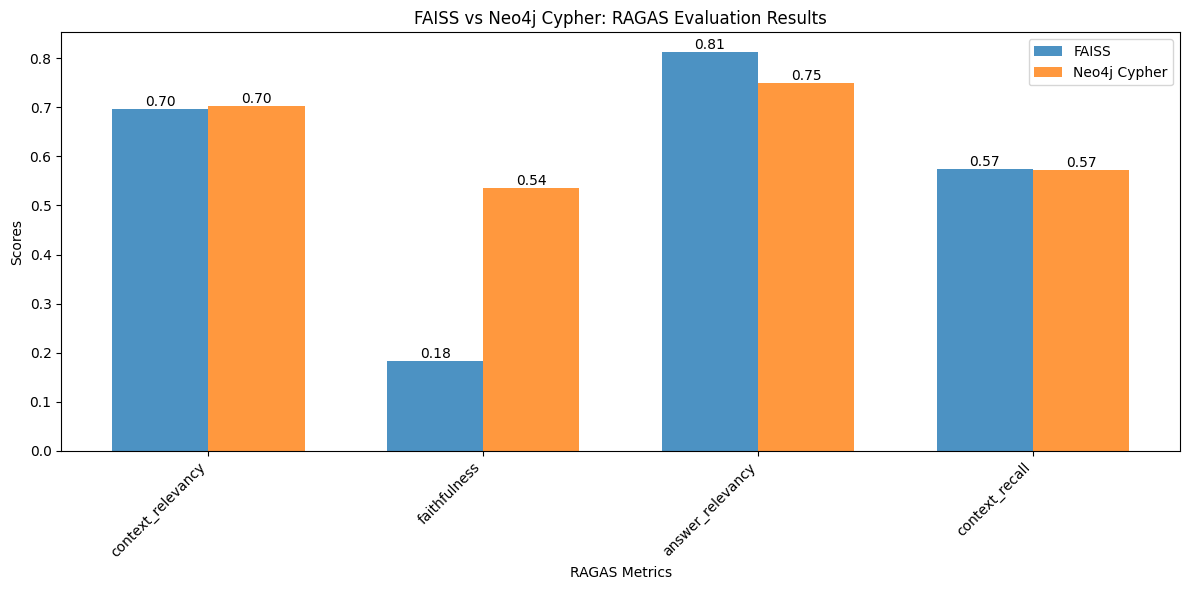

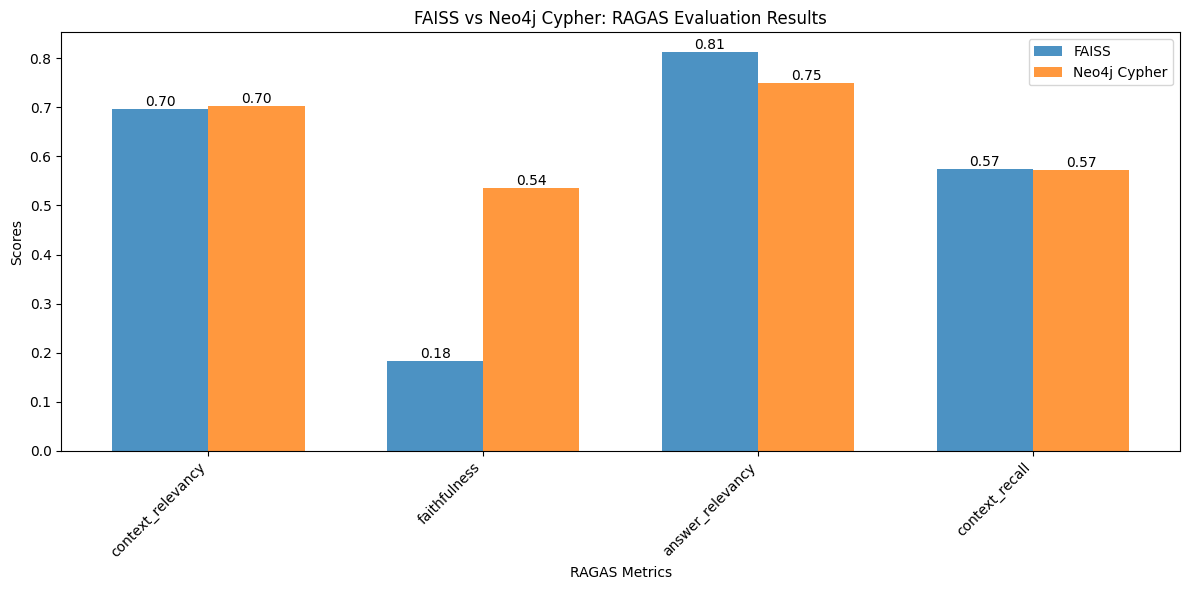

Results for FAISS:
{'context_relevancy': 0.6958, 'faithfulness': 0.1834, 'answer_relevancy': 0.8124, 'context_recall': 0.5750}

Results for Neo4j Cypher:
{'context_relevancy': 0.7025, 'faithfulness': 0.5362, 'answer_relevancy': 0.7502, 'context_recall': 0.5733}



In [87]:
nest_asyncio.apply()
if __name__ == "__main__":
    nest_asyncio.apply()
    try:
        results = asyncio.run(asyncio.wait_for(main(), timeout=7200))  # 2 hour timeout
        plot_results(results)
        
        # Print detailed results
        for name, result in results.items():
            print(f"Results for {name}:")
            print(result)
            print()
    except asyncio.TimeoutError:
        print("Evaluation timed out after 2 hours.")
    finally:
        # Close the Neo4j driver
        driver.close()